## Assignment #1 - Volume and taper estimation

### Part 1 - Tree 24 measurements

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vol_eqs import VollibWrapper
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# IMPORTANT: Update this path to your vollib DLL location
DLL_PATH = r"D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll"

print("=== Forest Inventory Analysis Using VOLLIB ===")
print("Analysis of Lubrecht Experimental Forest Plot 9\n")

# Initialize the VOLLIB wrapper
try:
    vol_estimator = VollibWrapper(dll_path=DLL_PATH)
    print("✓ VOLLIB DLL loaded successfully")
except Exception as e:
    print(f"✗ Error loading VOLLIB DLL: {e}")
    print("Please update the DLL_PATH variable to match your system")
    raise

# Load the plot data from Excel file
try:
    plot_data = pd.read_excel('lef_plot9.xlsx', sheet_name=0)  # First sheet
    species_codes = pd.read_csv('fia_treenames.csv')
    plot_data = plot_data.merge(species_codes[['FIA Code', 'Common Name']], left_on='SPCD', right_on='FIA Code', how='left')
    plot_data.rename(columns={'Common Name': 'SpeciesName'}, inplace=True)
    print("Plot data loaded successfully")
    print(f"Dataset contains {len(plot_data)} trees")
except FileNotFoundError:
    print("Excel file 'lef_plot9.xlsx' not found")

=== Forest Inventory Analysis Using VOLLIB ===
Analysis of Lubrecht Experimental Forest Plot 9

✓ VOLLIB DLL loaded successfully
Plot data loaded successfully
Dataset contains 33 trees


In [12]:
tree24 = plot_data[plot_data['TreeID'] == 24].iloc[0]

print(f"\nTree 24 Characteristics:")
print(f"Species: {tree24['SpeciesName']} (Code: {tree24['SPCD']})")
print(f"DBH: {tree24['DBH']:.1f} inches")
print(f"Total Height: {tree24['TotHeight']:.1f} feet")

tree_params = {
    "region": 1, "forest": "16", "district": "01",
    "species_code": int(tree24['SPCD']),
    "dbh": tree24['DBH'], "height": tree24['TotHeight'],
}

try:
    total_cuft = vol_estimator.calc_total_cubic_ft(**tree_params)
    merch_cuft = vol_estimator.calc_merch_cubic_ft(**tree_params, merch_top_dib_primary=4.0)
    
    basal_area = 0.005454154 * (tree24['DBH'] ** 2)
    
    print(f"\nVolume Calculations for Tree 24:")
    print(f"Basal Area: {basal_area:.3f} sq ft")
    print(f"Total Cubic Volume: {total_cuft:.2f} cu ft")
    print(f"Merchantable Volume (4\" top): {merch_cuft:.2f} cu ft")
    
    tree_params_temp = tree_params.copy()
    # remove dbh and height for equation retrieval
    tree_params_temp.pop('dbh')
    tree_params_temp.pop('height')
    voleq = vol_estimator._get_volume_equation(**tree_params_temp)
    print(f"\nVolume Equation Used: {voleq}")
    
except Exception as e:
    print(f"Error in volume calculations: {e}")
    total_cuft = merch_cuft = 0
    basal_area = 0.005454154 * (tree24['DBH'] ** 2)

print(f"\nEquation Description:")
print(f"The specific equation chosen was {voleq}.  This equation is selected based on the species, region, and forest type of the tree.")


Tree 24 Characteristics:
Species: western larch (Code: 73)
DBH: 17.9 inches
Total Height: 107.0 feet

Volume Calculations for Tree 24:
Basal Area: 1.748 sq ft
Total Cubic Volume: 63.70 cu ft
Merchantable Volume (4" top): 57.70 cu ft

Volume Equation Used: I00FW2W073

Equation Description:
The specific equation chosen was I00FW2W073.  This equation is selected based on the species, region, and forest type of the tree.


### Part 2 - Tree 24 taper profile


Taper Profile Data (first 10 points):
 height_ft    dob_in    dib_in
       1.0 22.874405 17.886278
       2.0 20.609877 16.685486
       3.0 19.215843 15.924394
       4.0 18.265102 15.396261
       5.0 17.564985 15.009604
       6.0 17.083824 14.715923
       7.0 16.730036 14.486467
       8.0 16.454094 14.302851
       9.0 16.229458 14.152652
      10.0 16.042849 14.027126

Girard Form Class: 75.1


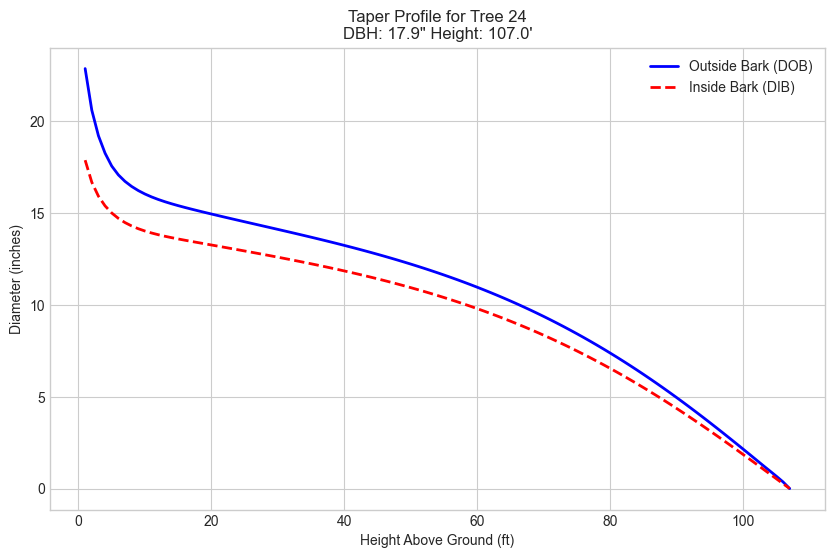

In [18]:
full_report = vol_estimator.get_full_report(**tree_params)
taper_data = full_report['taper_data']

print(f"\nTaper Profile Data (first 10 points):")
print(taper_data.head(10).to_string(index=False))
dib_17_3 = np.interp(17.3, taper_data['height_ft'], taper_data['dib_in'])
gfc = (dib_17_3 / tree24['DBH']) * 100
print(f"\nGirard Form Class: {gfc:.1f}")

plt.figure(figsize=(10, 6))
plt.plot(taper_data['height_ft'], taper_data['dob_in'], 
         'b-', linewidth=2, label='Outside Bark (DOB)')
plt.plot(taper_data['height_ft'], taper_data['dib_in'], 
         'r--', linewidth=2, label='Inside Bark (DIB)')
plt.xlabel('Height Above Ground (ft)')
plt.ylabel('Diameter (inches)')
plt.title(f'Taper Profile for Tree 24\nDBH: {tree24["DBH"]:.1f}" Height: {tree24["TotHeight"]:.1f}\'')
plt.legend()
plt.show()

### Part 3 - Alternate tree type

Comparing Tree 24 if it were an Engelmann spruce instead of a Douglas-fir.

Volume Comparison:
              Metric Douglas-fir Engelmann spruce
Total Volume (cu ft)       63.70            75.40
Merch Volume (cu ft)       57.70            67.50


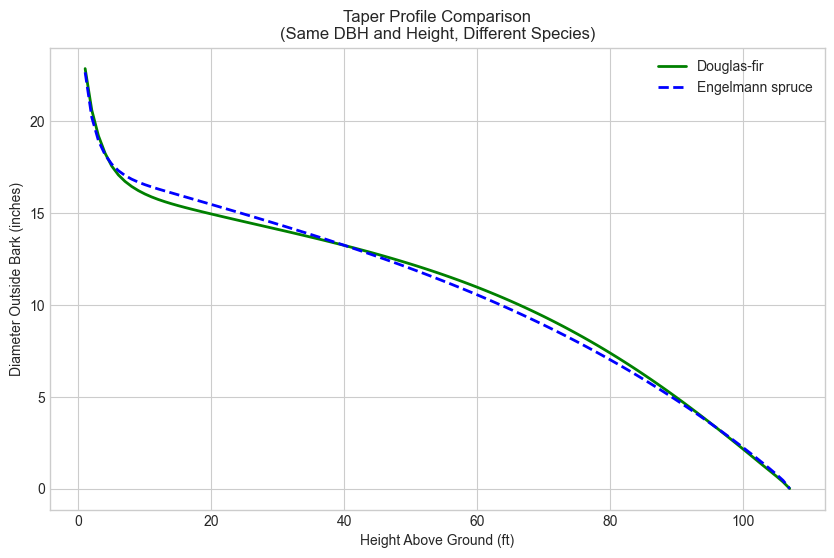


Species Differences Explanation:
Different tree species have different shapes (allometry). Engelmann spruce
is typically less tapered (more excurrent) than Douglas-fir. The NVEL
equations capture these species-specific growth patterns, often resulting
in higher volume estimates for spruce compared to a fir of the same DBH and height.


In [ ]:
print("Comparing Tree 24 if it were an Engelmann spruce instead of a Douglas-fir.")

es_params = tree_params.copy()
es_params['species_code'] = 93  # Engelmann Spruce FIA code

es_total_cuft = vol_estimator.calc_total_cubic_ft(**es_params)
es_merch_cuft = vol_estimator.calc_merch_cubic_ft(**es_params, merch_top_dib_primary=4.0)

comparison_df = pd.DataFrame({
    'Metric': ['Total Volume (cu ft)', 'Merch Volume (cu ft)'],
    'Douglas-fir': [f"{total_cuft:.2f}", f"{merch_cuft:.2f}"],
    'Engelmann spruce': [f"{es_total_cuft:.2f}", f"{es_merch_cuft:.2f}"]
})
print("\nVolume Comparison:")
print(comparison_df.to_string(index=False))
df_taper = vol_estimator.get_full_report(**tree_params)['taper_data']
es_taper = vol_estimator.get_full_report(**es_params)['taper_data']

if not df_taper.empty and not es_taper.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(df_taper['height_ft'], df_taper['dob_in'], 
             'g-', linewidth=2, label='Douglas-fir')
    plt.plot(es_taper['height_ft'], es_taper['dob_in'], 
             'b--', linewidth=2, label='Engelmann spruce')
    plt.xlabel('Height Above Ground (ft)')
    plt.ylabel('Diameter Outside Bark (inches)')
    plt.title('Taper Profile Comparison\n(Same DBH and Height, Different Species)')
    plt.legend()
    plt.show()
print(f"\nSpecies Differences Explanation:")
print("Different tree species have different shapes (allometry). Engelmann spruce")
print("is typically less tapered (more excurrent) than Douglas-fir. The NVEL")
print("equations capture these species-specific growth patterns, often resulting")
print("in higher volume estimates for spruce compared to a fir of the same DBH and height.")

### Part 4 - All tree measurements

In [25]:
live_trees = plot_data[(plot_data['Status'] == 1) & (plot_data['DBH'] >= 5.0)].copy()

print(f"Analyzing {len(live_trees)} live trees ≥ 5\" DBH")

def calculate_tree_volumes(row):
    """Calculates volumes and BA for a single tree row."""
    try:
        params = {
            "region": 1, "forest": "16", "district": "01",
            "species_code": int(row['SPCD']),
            "dbh": row['DBH'], "height": row['TotHeight'],
        }
        params_temp = params.copy()
        # remove dbh and height for equation retrieval
        params_temp.pop('dbh', None)
        params_temp.pop('height', None)
        voleq = vol_estimator._get_volume_equation(**params_temp)
        total_vol = vol_estimator.calc_total_cubic_ft(**params)
        merch_vol = vol_estimator.calc_merch_cubic_ft(**params, merch_top_dib_primary=4.0)
        basal_area = 0.005454154 * (row['DBH'] ** 2)
        
        return pd.Series({
            'basalAreasqft': basal_area, 'totVol': total_vol,
            'merchVol': merch_vol, 'volEQnum': voleq
        })
    except Exception:
        basal_area = 0.005454154 * (row['DBH'] ** 2)
        return pd.Series({
            'basalAreasqft': basal_area, 'totVol': 0,
            'merchVol': 0, 'volEQnum': 'Error'
        })

print("Calculating volumes for all trees...")
volume_results = live_trees.apply(calculate_tree_volumes, axis=1)
live_trees = pd.concat([live_trees, volume_results], axis=1)

display_cols = ['TreeID', 'SpeciesName', 'DBH', 'TotHeight', 
                'basalAreasqft', 'totVol', 'merchVol', 'volEQnum']
print(f"\nTree-Level Results:")
print(live_trees[display_cols].round(2).to_string())

Analyzing 29 live trees ≥ 5" DBH
Calculating volumes for all trees...

Tree-Level Results:
    TreeID    SpeciesName   DBH  TotHeight  basalAreasqft  totVol  merchVol    volEQnum
0        1  western larch   8.0       61.0           0.35     8.0       6.5  I00FW2W073
1        2  western larch  16.1       93.0           1.41    45.3      42.3  I00FW2W073
2        3    Douglas-fir   7.3       34.0           0.29     3.8       2.3  I00FW2W202
3        4    Douglas-fir  15.8       88.0           1.36    42.9      40.4  I00FW2W202
4        5    Douglas-fir   8.4       68.0           0.38    10.4       8.4  I00FW2W202
5        6  western larch   7.1       68.0           0.27     7.3       5.4  I00FW2W073
6        7  western larch   7.8       78.0           0.33    10.2       8.2  I00FW2W073
7        8  western larch   8.6       71.0           0.40    10.9       9.1  I00FW2W073
8        9  western larch   8.6       82.0           0.40    12.8      11.1  I00FW2W073
9       10    Douglas-fir   8

### Part 5 - Aggregate plot-level statistics